In [1]:
%reload_ext eradiate.notebook.tutorials

*Last updated: 2024-05-28 11:38 (eradiate v0.27.0rc2.dev10+g2e49409d.d20240527)*

## Imports

As for all tutorials the first step is to import all necessary classes and create aliases for convenience:

In [2]:
%load_ext eradiate

import eradiate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

eradiate.set_mode("ckd")
eradiate.config.progress = "spectral_loop"

from eradiate import unit_registry as ureg

## Visualizing the pipeline

We set up a basic simulation to visualize its post-processing pipeline:

In [3]:
exp = eradiate.experiments.AtmosphereExperiment(
    illumination={
        "type": "directional",
        "zenith": 30,
    },
    measures={
        "type": "mdistant",
        "construct": "hplane",
        "azimuth": 0.0,
        "zeniths": np.arange(-75.0, 76.0, 5.0),
        "srf": "sentinel_2a-msi-3",
        "spp": 10000,
    }
)

In [4]:
drv = exp.pipeline(0)

The Driver defines how post-processing operations chain with each other, builds a graph to represent the pipeline and specifies the input, output and intermediate data handled during workflow execution. The Driver instance has a method to display its internal graph:

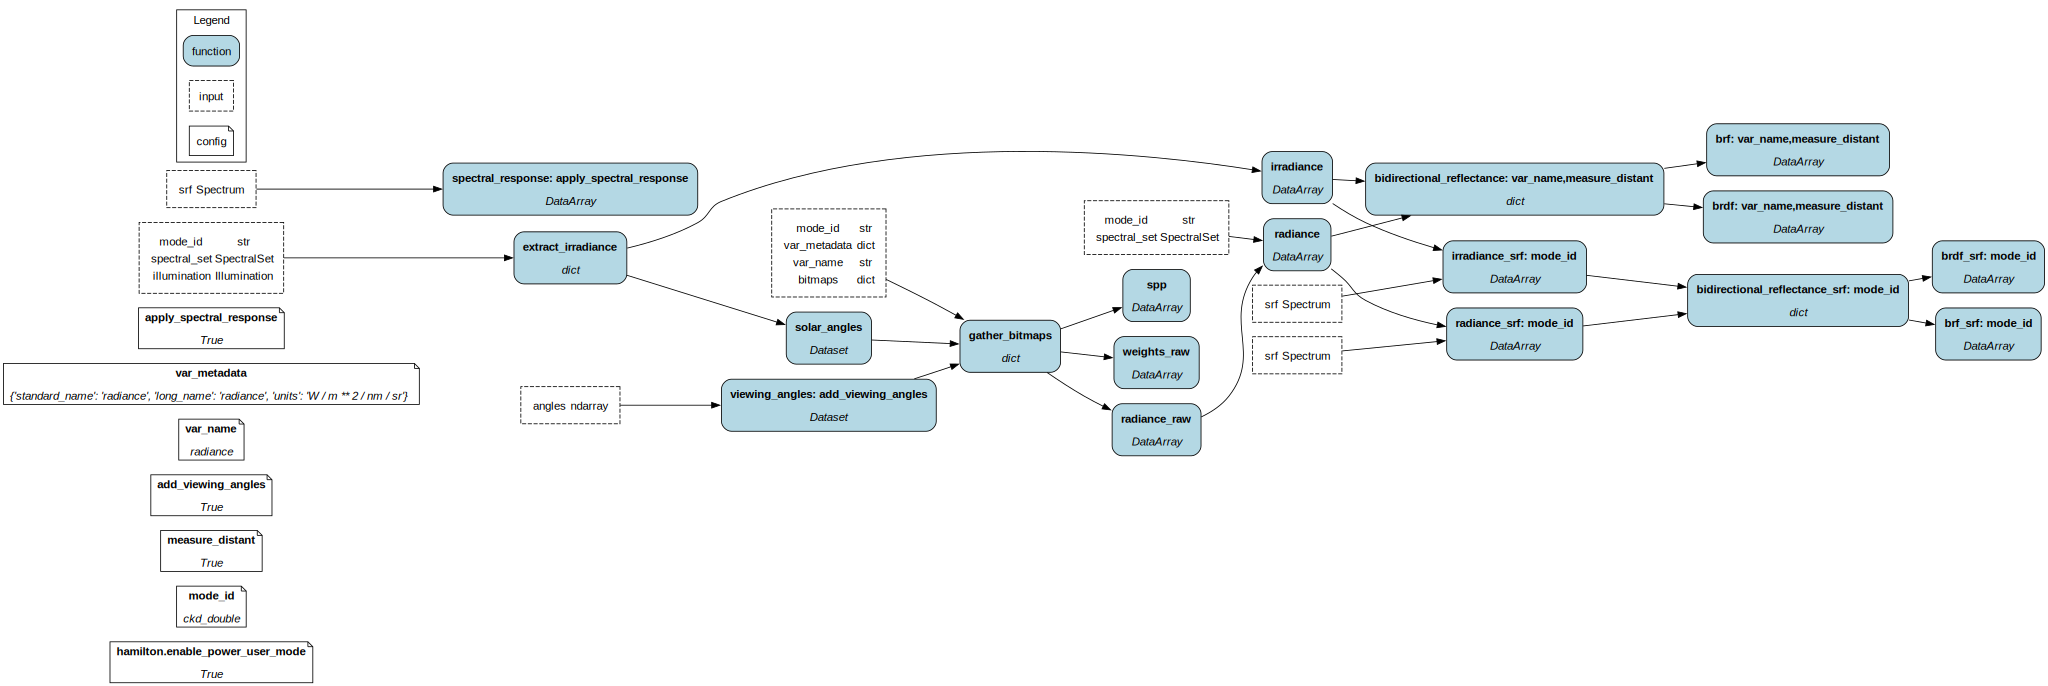

In [5]:
drv.display_all_functions()

On this graph, we can see all the functions that will be executed during post-processing, as well as the inputt and configuration variables, together with their corresponding data types. We can also list the variables as a table:

In [6]:
eradiate.pipelines.list_variables(drv, as_table=True)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Name                          ┃ Type         ┃ Input ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━┩
│ angles                        │ ndarray      │ x     │
│ bitmaps                       │ dict         │ x     │
│ illumination                  │ Illumination │ x     │
│ spectral_set                  │ SpectralSet  │ x     │
│ srf                           │ Spectrum     │ x     │
│ bidirectional_reflectance     │ dict         │       │
│ bidirectional_reflectance_srf │ dict         │       │
│ brdf                          │ DataArray    │       │
│ brdf_srf                      │ DataArray    │       │
│ brf                           │ DataArray    │       │
│ brf_srf                       │ DataArray    │       │
│ extract_irradiance            │ dict         │       │
│ gather_bitmaps                │ dict         │       │
│ irradiance                    │ DataArray    │       │
│ irradiance_srf                │ DataArray    │       │
│ radiance                      │ DataArray    │       │
│ radiance_raw                  │ DataArray    │       │
│ radiance_srf                  │ DataArray    │       │
│ solar_angles                  │ Dataset      │       │
│ spectral_response             │ DataArray    │       │
│ spp                           │ DataArray    │       │
│ viewing_angles                │ Dataset      │       │
│ weights_raw                   │ DataArray    │       │
└───────────────────────────────┴──────────────┴───────┘

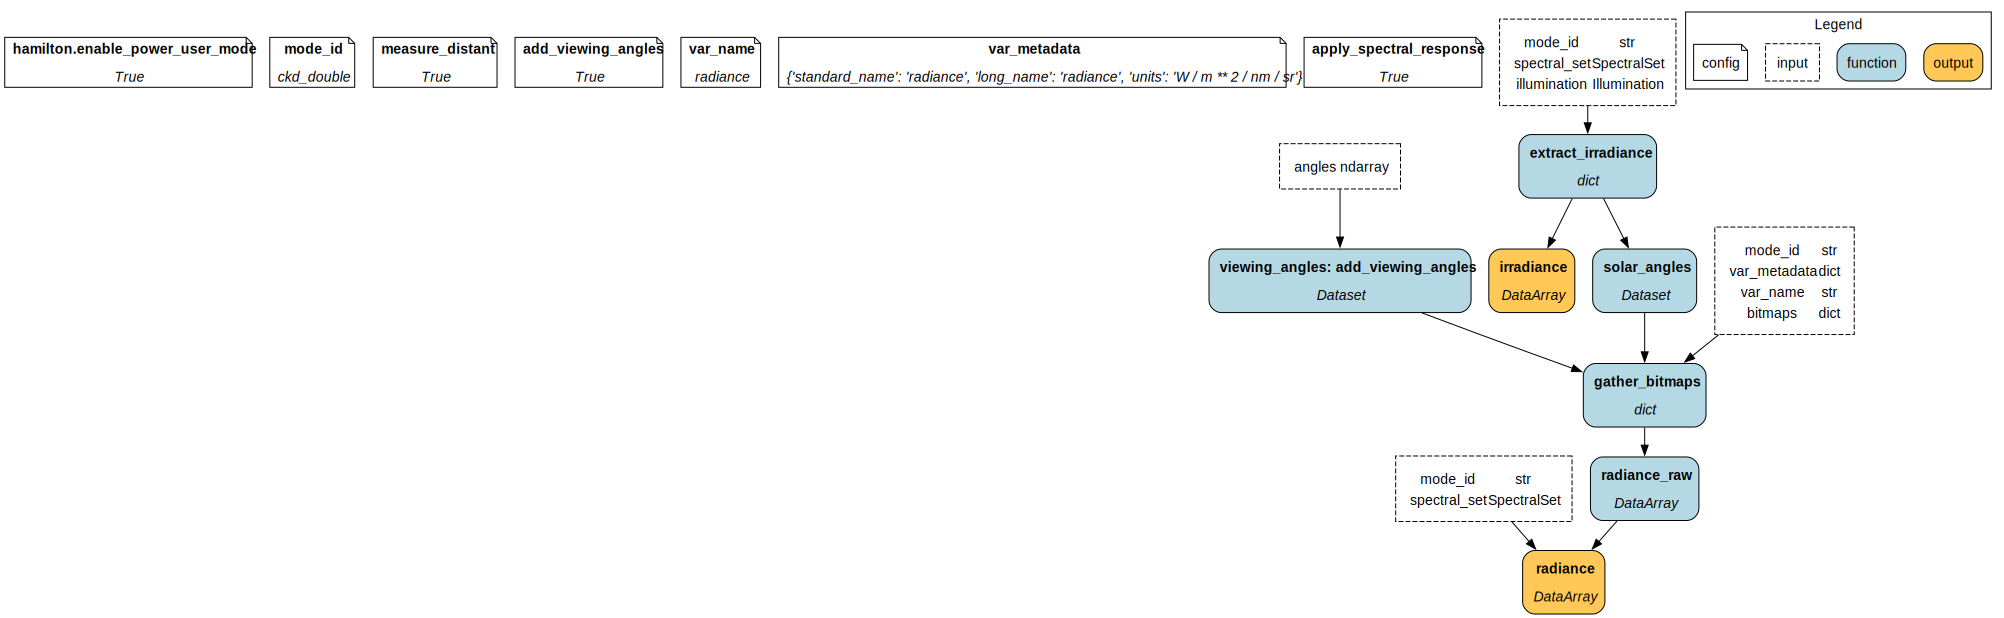

In [7]:
drv.visualize_execution(
    final_vars=["radiance", "irradiance"],
    inputs={"angles": None, "bitmaps": None, "illumination": None, "spectral_set": None},
    orient="TD",
)

We can see that Hamilton pruned the global graph to execute only the nodes that will contribute to the requested variables. We can also request intermediate outputs in a similar way:

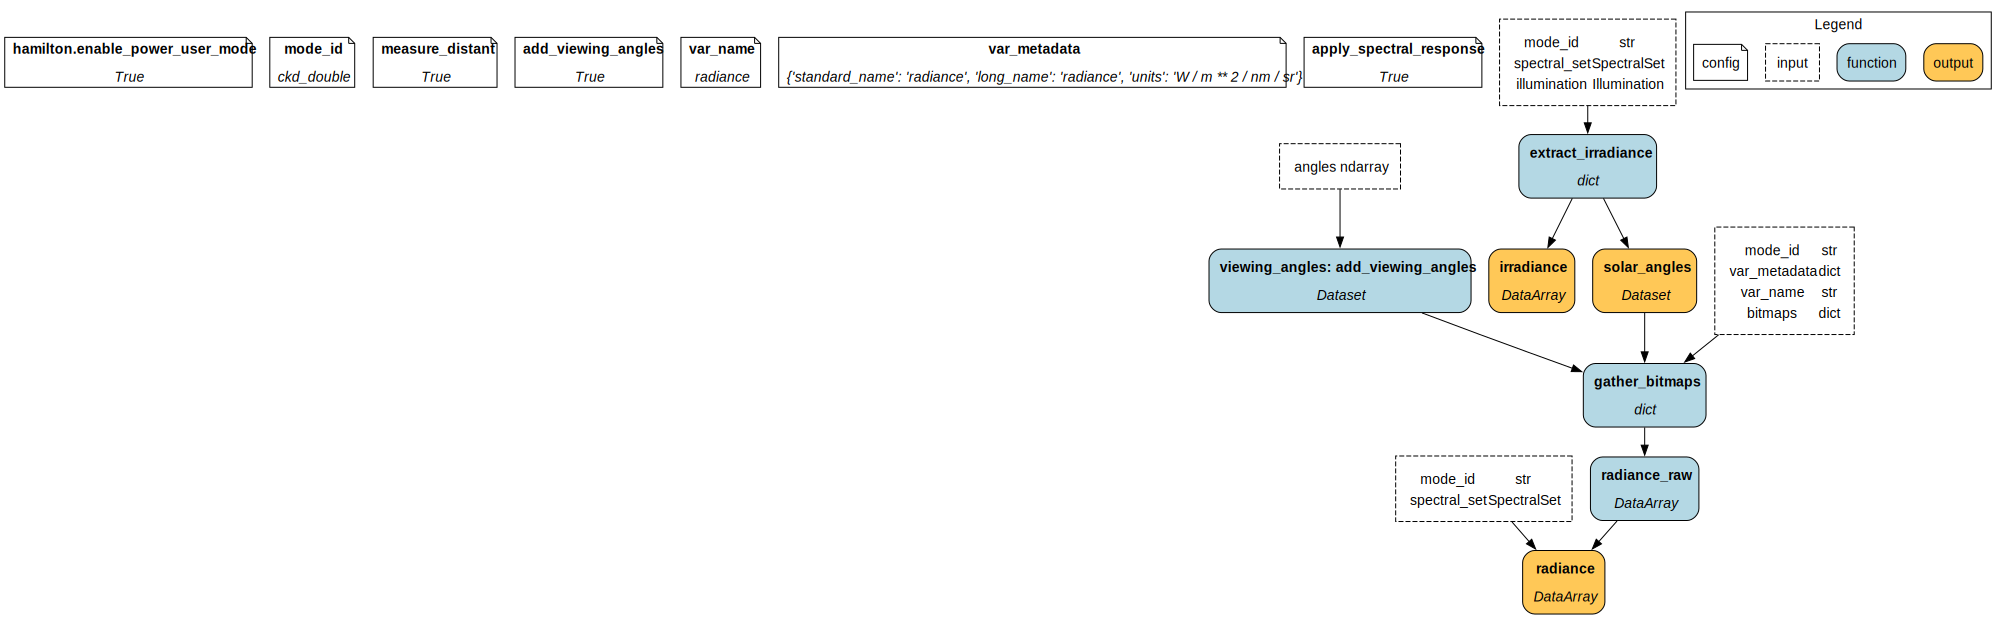

In [8]:
drv.visualize_execution(
    final_vars=["radiance", "irradiance", "solar_angles"],
    inputs={"angles": None, "bitmaps": None, "illumination": None, "spectral_set": None},
    orient="TD",
)

With this, we have the basic tool to understand which are the input and output variable of the post-processing pipeline. Now, let's see how to use it.

## Running the pipeline

If you use the recommended workflow to run an experiment, the post-processing pipeline execution is performed automatically. A list of experiment-specific post-processing outputs are automatically assembled into an xarray dataset.

In [9]:
eradiate.run(exp)

0/6|          | 00:00, ETA=?

<xarray.Dataset> Size: 6kB
Dimensions:         (sza: 1, saa: 1, w: 6, y_index: 1, x_index: 31)
Coordinates:
  * sza             (sza) int64 8B 30
  * saa             (saa) float64 8B 0.0
  * w               (w) float64 48B 535.0 545.0 555.0 565.0 575.0 585.0
  * y_index         (y_index) int64 8B 0
    y               (y_index) float64 8B 0.0
  * x_index         (x_index) int64 248B 0 1 2 3 4 5 6 ... 24 25 26 27 28 29 30
    x               (x_index) float64 248B 0.0 0.03333 0.06667 ... 0.9667 1.0
    vza             (x_index, y_index) float64 248B -75.0 -70.0 ... 70.0 75.0
    vaa             (x_index, y_index) float64 248B 0.0 0.0 0.0 ... 0.0 0.0 0.0
    bin_wmin        (w) float64 48B 530.0 540.0 550.0 560.0 570.0 580.0
    bin_wmax        (w) float64 48B 540.0 550.0 560.0 570.0 580.0 590.0
Data variables:
    radiance        (w, y_index, x_index, saa, sza) float64 1kB 0.3435 ... 0....
    radiance_srf    (y_index, x_index, saa, sza) float64 248B 0.3241 ... 0.3628
    irradiance_srf  (sza, saa) float64 8B 1.64
    brdf            (w, y_index, x_index, saa, sza) float64 1kB 0.205 ... 0.2155
    brf             (w, y_index, x_index, saa, sza) float64 1kB 0.644 ... 0.6769
    brdf_srf        (y_index, x_index, saa, sza) float64 248B 0.1976 ... 0.2212
    brf_srf         (y_index, x_index, saa, sza) float64 248B 0.6209 ... 0.695
    irradiance      (sza, saa, w) float64 48B 1.676 1.653 1.669 ... 1.611 1.594

In [10]:
exp.clear()
exp.process()
exp.postprocess()
exp.results["measure"]

0/6|          | 00:00, ETA=?

<xarray.Dataset> Size: 6kB
Dimensions:         (sza: 1, saa: 1, w: 6, y_index: 1, x_index: 31)
Coordinates:
  * sza             (sza) int64 8B 30
  * saa             (saa) float64 8B 0.0
  * w               (w) float64 48B 535.0 545.0 555.0 565.0 575.0 585.0
  * y_index         (y_index) int64 8B 0
    y               (y_index) float64 8B 0.0
  * x_index         (x_index) int64 248B 0 1 2 3 4 5 6 ... 24 25 26 27 28 29 30
    x               (x_index) float64 248B 0.0 0.03333 0.06667 ... 0.9667 1.0
    vza             (x_index, y_index) float64 248B -75.0 -70.0 ... 70.0 75.0
    vaa             (x_index, y_index) float64 248B 0.0 0.0 0.0 ... 0.0 0.0 0.0
    bin_wmin        (w) float64 48B 530.0 540.0 550.0 560.0 570.0 580.0
    bin_wmax        (w) float64 48B 540.0 550.0 560.0 570.0 580.0 590.0
Data variables:
    radiance        (w, y_index, x_index, saa, sza) float64 1kB 0.3388 ... 0....
    radiance_srf    (y_index, x_index, saa, sza) float64 248B 0.3215 ... 0.3621
    irradiance_srf  (sza, saa) float64 8B 1.64
    brdf            (w, y_index, x_index, saa, sza) float64 1kB 0.2021 ... 0....
    brf             (w, y_index, x_index, saa, sza) float64 1kB 0.6351 ... 0....
    brdf_srf        (y_index, x_index, saa, sza) float64 248B 0.196 ... 0.2208
    brf_srf         (y_index, x_index, saa, sza) float64 248B 0.6158 ... 0.6936
    irradiance      (sza, saa, w) float64 48B 1.676 1.653 1.669 ... 1.611 1.594

Finally, we can decide to run the post-processing pipeline manually:

In [11]:
i_measure = 0
drv = exp.pipeline(i_measure)
outputs = ["brf"]
inputs = {
    "angles": exp.measures[i_measure].viewing_angles.m_as("deg"),
    "illumination": exp.illumination,
    "bitmaps": exp.measures[i_measure].mi_results,
    "spectral_set": exp.spectral_set[i_measure]
}
results = drv.execute(final_vars=outputs, inputs=inputs)

The result dictionary maps output variable names with their computed values. In our case, we have a single `"brf"` field:

In [12]:
results["brf"]

<xarray.DataArray 'brf' (w: 6, y_index: 1, x_index: 31, saa: 1, sza: 1)> Size: 1kB
0.6351 0.6295 0.6155 0.6097 0.615 0.6051 ... 0.6725 0.6793 0.6882 0.6875 0.6866
Coordinates:
  * sza       (sza) int64 8B 30
  * saa       (saa) float64 8B 0.0
  * w         (w) float64 48B 535.0 545.0 555.0 565.0 575.0 585.0
  * y_index   (y_index) int64 8B 0
    y         (y_index) float64 8B 0.0
  * x_index   (x_index) int64 248B 0 1 2 3 4 5 6 7 8 ... 23 24 25 26 27 28 29 30
    x         (x_index) float64 248B 0.0 0.03333 0.06667 ... 0.9333 0.9667 1.0
    vza       (x_index, y_index) float64 248B -75.0 -70.0 -65.0 ... 70.0 75.0
    vaa       (x_index, y_index) float64 248B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    bin_wmin  (w) float64 48B 530.0 540.0 550.0 560.0 570.0 580.0
    bin_wmax  (w) float64 48B 540.0 550.0 560.0 570.0 580.0 590.0
Attributes:
    standard_name:  brf
    long_name:      bi-directional reflectance factor
    units:

This spectral radiance array can then be processed and plotted using regular xarray facilities:

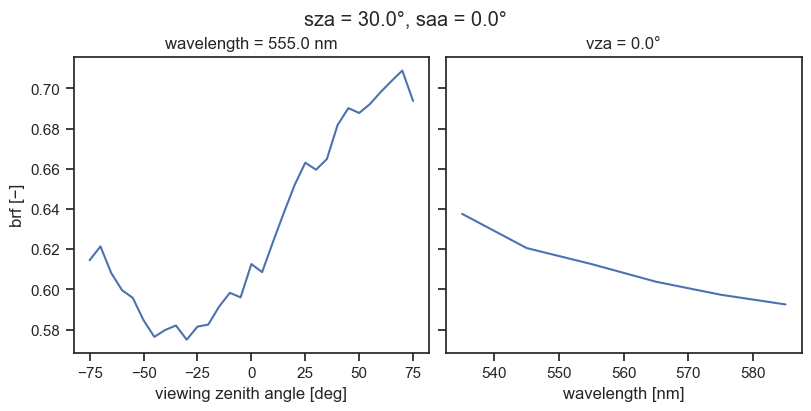

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True, layout="constrained")
brf = results["brf"]

# Slice along the spectral dimension to get the reflectance for the bin closest to 550 nm 
brf_550 = brf.sel(w=550, method="nearest")
brf_550.squeeze(drop=True).plot(ax=axs[0], x="vza")
axs[0].set_title(f"wavelength = {float(brf_550.w)} nm")
axs[0].set_ylabel("brf [−]")

# Select along the viewing angle dimension to get the reflectance at the nadir view
brf_nadir = brf.where(brf.vza == 0.0, drop=True)
brf_nadir.squeeze(drop=True).plot(ax=axs[1])
axs[1].set_title(f"vza = {float(brf_nadir.vza)}°")
axs[1].set_ylabel("")

fig.suptitle(f"sza = {float(brf.sza)}°, saa = {float(brf.saa)}°")
plt.show()
plt.close()

Note that this type of manual operation is usually unnecessary, because the default pipeline will run very quickly and should contain all relevant output variables.

## Running custom post-processing operations

So far, we have been manipulating manually the default post-processing pipeline. Sometimes, however, we might want to do more than what this default pipeline can do. While writing a custom pipeline is possible, it is most often an unnecessary time investment, and we have a much simpler approach to build a custom, single-use post-processing chain. In this section, we will collect intermediate data and apply post-processing routines directly to build our customized output dataset.

As a supporting case, we consider a simulation in which we want to see what two similar instruments observing the same target will record. There are several ways to achieve this, listed here in increasing order of efficiency:

1. Set up two full-fledged experiments and run the Monte Carlo ray tracing simulation twice. This scenario is the most wasteful because it repeats all steps (experiment pre-processing, processing and post-processing) twice.
2. Set up a single experiment with two measures. This scenario wastes a little less computational time because it repeats only the ray tracing simulation.
3. Set up a single experiment covering the union of the spectral range covered by both sensors, extract the spectral signal and apply the spectral response function of both instruments as a custom post-processing step. This is the most efficient method.

We will see now how to implement method 3. We will simulate a signal recorded by the MSI instruments onboard Sentinel-2A and Sentinel–2B (bands 2, 3 and 4). Let us first have a look at their spectral response functions:

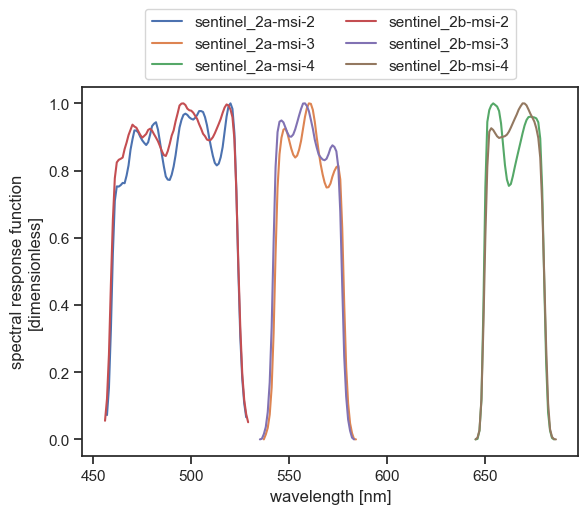

In [14]:
bands = [
    "sentinel_2a-msi-2",
    "sentinel_2a-msi-3",
    "sentinel_2a-msi-4",
    "sentinel_2b-msi-2",
    "sentinel_2b-msi-3",
    "sentinel_2b-msi-4",
]

srf_ds = {
    band: eradiate.data.load_dataset(f"spectra/srf/{band}.nc")
    for band in bands
}

fig, ax = plt.subplots(1, 1)
for band, ds in srf_ds.items():
    ds.srf.plot(label=band, ax=ax)
plt.legend(ncol=2, loc="lower center", bbox_to_anchor=(0.5, 1.0))
plt.show()
plt.close()

We can easily extract the bounds of the wavelength domain we should cover:

In [15]:
df = pd.DataFrame(
    {
        band: {"wmin": float(ds.w.min()), "wmax": float(ds.w.max())} 
        for band, ds in srf_ds.items()
    }
).T
print(f"wmin = {df.wmin.min()}")
print(f"wmax = {df.wmax.max()}")

wmin = 456.0
wmax = 686.0


In [16]:
exp = eradiate.experiments.AtmosphereExperiment(
    illumination={
        "type": "directional",
        "zenith": 30,
    },
    measures={
        "type": "mdistant",
        "construct": "hplane",
        "azimuth": 0.0,
        "zeniths": np.arange(-75.0, 76.0, 5.0),
        "srf": {
            "type": "multi_delta",
            "wavelengths": np.arange(450.0, 690.0, 1.0) * ureg.nm
        },
        "spp": 10000,
    }
)
result = eradiate.run(exp)
result

0/24|          | 00:00, ETA=?

<xarray.Dataset> Size: 20kB
Dimensions:     (sza: 1, saa: 1, w: 24, y_index: 1, x_index: 31)
Coordinates:
  * sza         (sza) int64 8B 30
  * saa         (saa) float64 8B 0.0
  * w           (w) float64 192B 455.0 465.0 475.0 485.0 ... 665.0 675.0 685.0
  * y_index     (y_index) int64 8B 0
    y           (y_index) float64 8B 0.0
  * x_index     (x_index) int64 248B 0 1 2 3 4 5 6 7 ... 23 24 25 26 27 28 29 30
    x           (x_index) float64 248B 0.0 0.03333 0.06667 ... 0.9333 0.9667 1.0
    vza         (x_index, y_index) float64 248B -75.0 -70.0 -65.0 ... 70.0 75.0
    vaa         (x_index, y_index) float64 248B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    bin_wmin    (w) float64 192B 450.0 460.0 470.0 480.0 ... 660.0 670.0 680.0
    bin_wmax    (w) float64 192B 460.0 470.0 480.0 490.0 ... 670.0 680.0 690.0
Data variables:
    radiance    (w, y_index, x_index, saa, sza) float64 6kB 0.3825 ... 0.2562
    brdf        (w, y_index, x_index, saa, sza) float64 6kB 0.2193 ... 0.2003
    brf         (w, y_index, x_index, saa, sza) float64 6kB 0.6888 ... 0.6294
    irradiance  (sza, saa, w) float64 192B 1.744 1.751 1.831 ... 1.309 1.279

In [17]:
from eradiate.scenes.spectra import InterpolatedSpectrum


# We need to create Eradiate Spectrum instances representing the SRF from the datasets
def srf_spectrum(ds):
    w = ureg.Quantity(ds.w.values, ds.w.attrs["units"])
    srf = ds.data_vars["srf"].values
    return InterpolatedSpectrum(quantity="dimensionless", wavelengths=w, values=srf)

We now proceed with the post-processing operation and aggregate the results into a single data array, each radiance array being indexed on a new `band` dimension:

In [18]:
from eradiate.pipelines.logic import apply_spectral_response

radiances_srf = []

for band in bands:
    srf = srf_spectrum(srf_ds[band])
    radiances_srf.append(apply_spectral_response(result.radiance, srf))

# Now, we concatenate all of these into a data array for convenience
radiance_srf = xr.concat(radiances_srf, dim="band").assign_coords({"band": bands})
radiance_srf

<xarray.DataArray 'radiance_srf' (band: 6, y_index: 1, x_index: 31, saa: 1,
                                  sza: 1)> Size: 1kB
0.3703 0.3728 0.3705 0.3633 0.3619 0.3585 ... 0.2628 0.2652 0.267 0.269 0.2709
Coordinates:
  * sza      (sza) int64 8B 30
  * saa      (saa) float64 8B 0.0
  * y_index  (y_index) int64 8B 0
    y        (y_index) float64 8B 0.0
  * x_index  (x_index) int64 248B 0 1 2 3 4 5 6 7 8 ... 23 24 25 26 27 28 29 30
    x        (x_index) float64 248B 0.0 0.03333 0.06667 ... 0.9333 0.9667 1.0
    vza      (x_index, y_index) float64 248B -75.0 -70.0 -65.0 ... 70.0 75.0
    vaa      (x_index, y_index) float64 248B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * band     (band) <U17 408B 'sentinel_2a-msi-2' ... 'sentinel_2b-msi-4'
Attributes:
    standard_name:  radiance_srf
    long_name:      radiance (SRF-weighted)
    units:          W / m ** 2 / nm / sr

And we can finally plot the resulting dataset using xarray's built-in plotting routines:

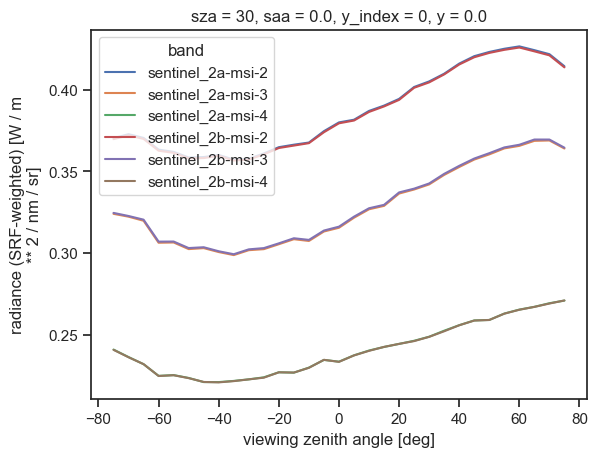

In [19]:
radiance_srf.plot(hue="band", x="vza")
plt.show()
plt.close()